<a href="https://colab.research.google.com/github/pglez82/IFCB_semisupervised/blob/master/IFCB_FT_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data
We are going to finetune a resnet18 and extract features with it

In [1]:
import os


if not os.path.isfile("IFCB_data.tar") and not os.path.isdir("data"):
  print("Data do not exist in local. Downloading...")
  !wget -O IFCB_data.tar https://unioviedo-my.sharepoint.com/:u:/g/personal/gonzalezgpablo_uniovi_es/Ec2z0uC4lghEg-9MjzoJ9QkBK5n74QjS-LszB9dlNrPfaw?download=1
else:
  print("Data already exists. Skipping download.")

if not os.path.isdir("data"):
  print("Extracting the tar file...")
  !tar -xf "IFCB_data.tar"
  print("Done. Removing the tar file.")
  !rm -f IFCB_data.tar #Remove the original file to save space

Data already exists. Skipping download.


# Download CSV with information about the images


In [2]:
import pandas as pd

if not os.path.isfile('IFCB.csv.zip'):
  print("CSV data do not exist. Downloading...")
  !wget -O IFCB.csv.zip "https://unioviedo-my.sharepoint.com/:u:/g/personal/gonzalezgpablo_uniovi_es/EfsVLhFsYJpPjO0KZlpWUq0BU6LaqJ989Re4XzatS9aG4Q?download=1"

data = pd.read_csv('IFCB.csv.zip',compression='infer', header=0,sep=',',quotechar='"')
print(data)

                        Sample  roi_number        OriginalClass  \
0        IFCB1_2006_158_000036           1                  mix   
1        IFCB1_2006_158_000036           2  Tontonia_gracillima   
2        IFCB1_2006_158_000036           3                  mix   
3        IFCB1_2006_158_000036           4                  mix   
4        IFCB1_2006_158_000036           5                  mix   
...                        ...         ...                  ...   
3457814  IFCB5_2014_353_205141        6850       Leptocylindrus   
3457815  IFCB5_2014_353_205141        6852                  mix   
3457816  IFCB5_2014_353_205141        6855                  mix   
3457817  IFCB5_2014_353_205141        6856                  mix   
3457818  IFCB5_2014_353_205141        6857                  mix   

              AutoClass FunctionalGroup  
0                   mix      Flagellate  
1           ciliate_mix         Ciliate  
2                   mix      Flagellate  
3                   mix    

# Create training set

Here we make a reestructuration of the images depending on which class we consider

In [3]:
import progressbar
from tqdm import tqdm
from shutil import copyfile
import numpy as np

tqdm.pandas()

classcolumn = "AutoClass" #Autoclass means 51 classes
#nclasses = 51 #Pick this number of most abundant classes to make sure that we do not have empty classes
yearstraining = ['2007'] #Years to consider as training
yearsvalidation = ['2008']
trainingfolder = "training"
validationfolder = "validation"

#In order to ensure that all tests have same number of classes, 
#classes=list(pd.crosstab(index=data[classcolumn],columns='count').sort_values('count',ascending=False)[0:nclasses].index)
#print("Considering %i classes" % len(classes))
#print(classes)
classes=np.unique(data[classcolumn])

print("Computing image paths...")
#Compute data paths
data['year'] = data['Sample'].str[6:10].astype(str)
data['path']="data"+'/'+data['year']+'/'+data['OriginalClass'].astype(str)+'/'+data['Sample'].astype(str)+'_'+data['roi_number'].apply(lambda x: str(x).zfill(5))+'.png'
print('Done')

#data[classcolumn][~data[classcolumn].isin(classes)]='mix' #Put ignored classes into mix category

#Check data by year
print(pd.crosstab(index=data['year'],columns='count'))

if not os.path.isdir(trainingfolder):
  print("Create folder structure for training set... Using years:")
  print(yearstraining)
  os.mkdir(trainingfolder)
  for folder in classes:
    os.mkdir(os.path.join(trainingfolder,folder))
  print("Done.\nMoving images to the respective folders...")
  data[data['year'].isin(yearstraining)].progress_apply(lambda row: copyfile(row['path'],os.path.join(trainingfolder,row[classcolumn],os.path.basename(row['path']))),axis=1)
  print("Done")
else:
  print("Training data already there... Doing nothing")

if not os.path.isdir(validationfolder):
  print("Create folder structure for the validation set... Using years:")
  print(yearsvalidation)
  os.mkdir(validationfolder)
  for folder in classes:
    os.mkdir(os.path.join(validationfolder,folder))
  print("Done.\nMoving images to the respective folders...")
  data[data['year'].isin(yearsvalidation)].progress_apply(lambda row: copyfile(row['path'],os.path.join(validationfolder,row[classcolumn],os.path.basename(row['path']))),axis=1)
  print("Done")  
else:
  print("Validation data already there... Doing nothing")


/home/pgonzalez/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Computing image paths...
Done
col_0   count
year         
2006   131002
2007   273080
2008   427308
2009   732398
2010   327996
2011   419692
2012   394766
2013   422255
2014   329322
Training data already there... Doing nothing
Validation data already there... Doing nothing


# Configure the process

In [4]:
import torch
import random


torch.manual_seed(0) #Reproducible
random.seed(0) #it seems that the transforms uses this random

num_workers = 4 # @param
batch_size = 256 # @param 
num_epochs_ft1 = 10 # @param
num_epochs_ft2 = 10 # @param
proportions = [0.01,0.2] #How many labelled examples do we take

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s"%device)

Using cuda:0


# Prepare de DataLoaders for the CNN
In this step it is important to consider that we have to use images with the same size than the original network (so we can reuse the weights)

In [5]:
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import math

def create_balanced_splits(train_dset,proportions):
  """
  This function creates different balanced splits following the proportions
  """
  y = np.array(train_dset.targets)
  classes, globalcounts = np.unique(y, return_counts=True) #If some classes do not have examples, they are not in y
  subsets = {}
  for p in proportions:
    subsets[p]=[]
    counts = np.rint(globalcounts*p)
    counts[counts==0]=1
    print("Building subset with %d elements"%sum(counts))
    for i in range(len(classes)):
      #print("For class %d we have %d examples and we are taking %d" % (classes[i],globalcounts[i],counts[i]))
      classelements, = np.where(y==classes[i])
      subsets[p].extend(classelements[0:int(counts[i])])
  return subsets

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

#Define transofrmations
train_transform = T.Compose([
  T.Resize(size=256),
  T.RandomResizedCrop(size=224),
  T.RandomHorizontalFlip(),
  T.ToTensor(),            
  #T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  #T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])
  

#Define data loader
train_loaders = {}
full_train_dset = ImageFolder(trainingfolder, transform=train_transform)
#train_classes = full_train_dset.classes
#num_classes = len(full_train_dset.classes)
num_classes = 51
indexes=create_balanced_splits(full_train_dset,proportions)
for p in proportions:
  train_dset=torch.utils.data.Subset(full_train_dset,indexes[p])
  train_loaders[p] = DataLoader(train_dset,batch_size=batch_size,num_workers=num_workers,shuffle=True)

val_dset = ImageFolder(validationfolder, transform=val_transform)
val_loader = DataLoader(val_dset,batch_size=batch_size,num_workers=num_workers)

Building subset with 2744 elements
Building subset with 54617 elements


# Plot some information about training and testing datasets

Text(0.5, 0.98, "Years['2008']")

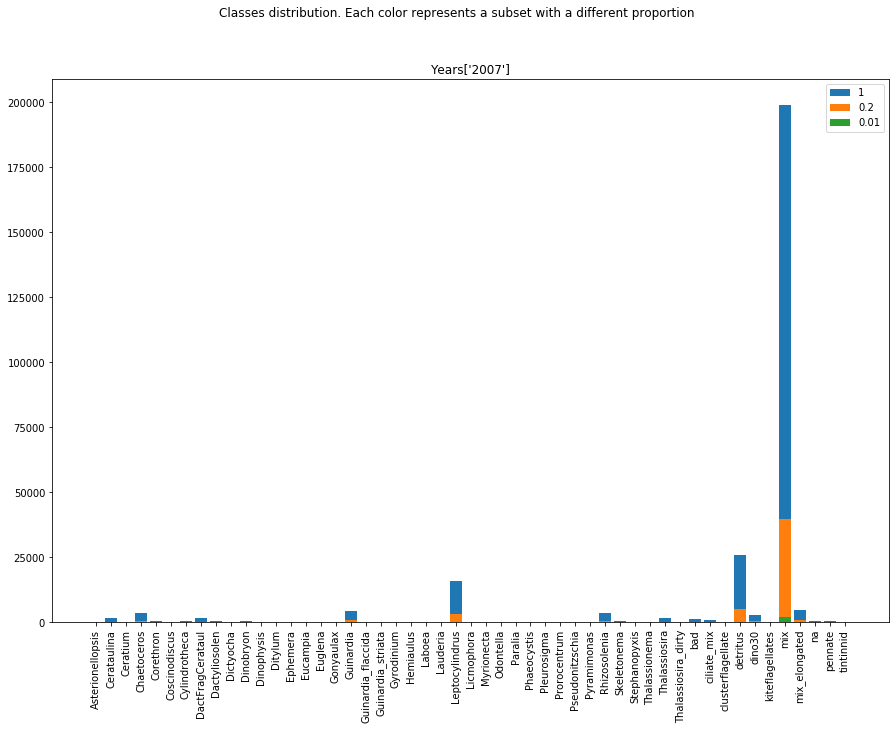

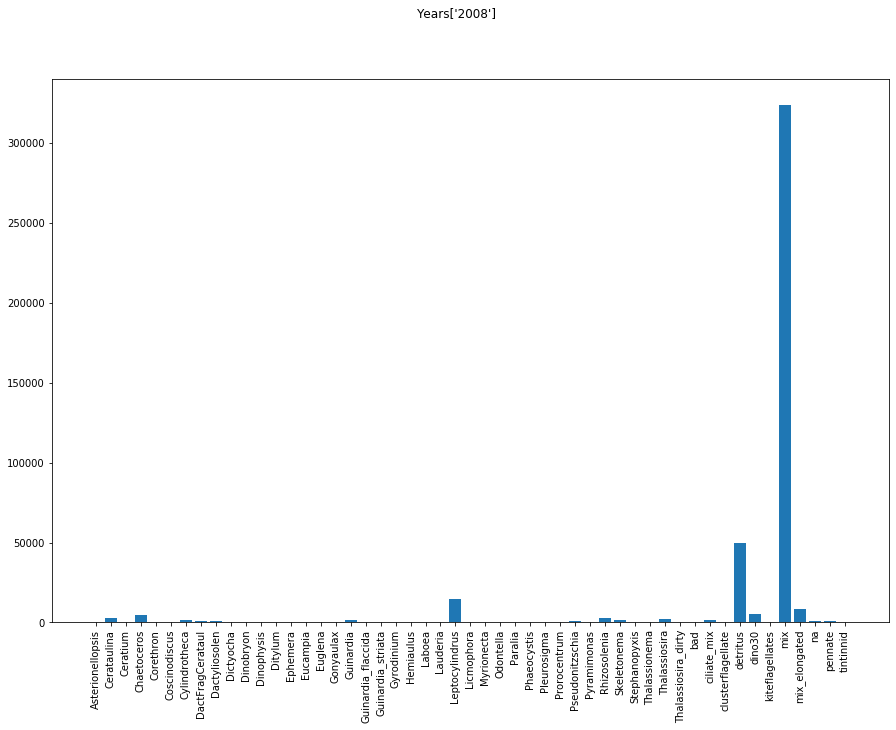

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def plot_dataset_distribution(y,labels):
  counts = np.bincount(y,minlength=len(labels))
  plt.bar(labels, counts)
  plt.xticks(rotation='vertical')

#Print training set and its subsets
figure(num=None, figsize=(15, 10),facecolor='w', edgecolor='k')
labels = full_train_dset.class_to_idx.keys()
y = np.array(full_train_dset.targets)
plot_dataset_distribution(y,labels)
for p in reversed(proportions):
  y = np.array(np.array(full_train_dset.targets)[indexes[p]])
  plot_dataset_distribution(y,labels)
plt.legend(['1']+list(reversed(proportions)))
plt.title('Years'+str(yearstraining))
plt.suptitle('Classes distribution. Each color represents a subset with a different proportion')
    
#Print validation dataset
fig=figure(num=None, figsize=(15, 10),facecolor='w', edgecolor='k')
y = np.array(val_dset.targets)
plot_dataset_distribution(y,labels)
fig.suptitle('Years'+str(yearsvalidation))


# Define how to load the CNN
In this step we download a pretrained CNN with the weights from ImageNet. We change the last layer to match the number of classes that we have in our problem

In [7]:
import torch.nn as nn

def load_network():
  model = torchvision.models.resnet18(pretrained=True)
  print("Adjusting the CNN for %s classes" % num_classes)
  model.fc = nn.Linear(model.fc.in_features, num_classes)
  #Define loss function
  loss_fn = nn.CrossEntropyLoss()
  model = model.to(device)
  return model,loss_fn

# Define finetuning util functions

In [8]:
import time

def run_epoch(model, loss_fn, loader, optimizer, device):
  """
  Train the model for one epoch.
  """
  loss_epoch = 0
  start_time = time.time()
  # Set the model to training mode
  model.train()
  for step, (x, y) in enumerate(loader):
    
    x = x.to(device)
    y = y.to(device)

    # Run the model forward to compute scores and loss.
    scores = model(x)
    loss = loss_fn(scores, y)
    loss_epoch = loss_epoch + loss.item()
    # Run the model backward and take a step using the optimizer.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 50== 0:
      spent = time.time()-start_time
      print(f"Step [{step}/{len(loader)}]\t Loss: {loss.item()} \t Time: {spent} secs [{(batch_size*50)/spent} ej/sec]]")
      start_time = time.time()
  return loss_epoch

def make_preds(model, loader, device):
  """
  Check the accuracy of the model.
  """
  # Set the model to eval mode
  model.eval()
  y_true = []
  y_pred = []
  for x, y in loader:
    x = x.to(device)
    y = y.to(device)
    # Run the model forward, and compare the argmax score with the ground-truth
    # category.
    output = model(x)
    predicted = output.argmax(1)
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
  return y_true,y_pred

# Define the finetuning
First we only update the last layer for a few epochs, then we update all the weights with a small learning rate

In [9]:
def finetune(model,loss_fn,train_loader,device):
  for param in model.parameters():
    param.requires_grad = False
  for param in model.fc.parameters():
    param.requires_grad = True

  optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

  #First phase of finetuning
  for epoch in range(num_epochs_ft1):
    # Run an epoch over the training data.
    print('Starting epoch %d / %d' % (epoch + 1,num_epochs_ft1))
    loss_epoch = run_epoch(model, loss_fn, train_loader, optimizer, device)

    # Check accuracy on the train and val sets.
    print(f"Epoch [{epoch+1}/{num_epochs_ft1}]\t Loss: {loss_epoch / len(train_loader)}")

  #Allow updating all the weights in the second phase
  for param in model.parameters():
    param.requires_grad = True

  #Lower learning rate this time
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

  # Train the entire model for a few more epochs, checking accuracy on the
  # train sets after each epoch.
  for epoch in range(num_epochs_ft2):
    print('Starting epoch %d / %d' % (epoch + 1, num_epochs_ft2))
    loss_epoch = run_epoch(model, loss_fn, train_loader, optimizer, device)

    print(f"Epoch [{epoch+1}/{num_epochs_ft2}]\t Loss: {loss_epoch / len(train_loader)}")
    
  print("Performing final validation in test examples...")
  y_true,y_pred = make_preds(model, val_loader, device)
  return y_true,y_pred


# Execute everything and print the results

Starting process for proportion 0.010000
Adjusting the CNN for 51 classes
Starting epoch 1 / 10
Step [0/11]	 Loss: 4.728701114654541 	 Time: 1.2025234699249268 secs [10644.28289353812 ej/sec]]
Epoch [1/10]	 Loss: 2.3792236718264492
Starting epoch 2 / 10
Step [0/11]	 Loss: 1.6990790367126465 	 Time: 1.1935603618621826 secs [10724.216729206348 ej/sec]]
Epoch [2/10]	 Loss: 1.397928996519609
Starting epoch 3 / 10
Step [0/11]	 Loss: 1.1119424104690552 	 Time: 1.1675562858581543 secs [10963.06889444049 ej/sec]]
Epoch [3/10]	 Loss: 1.1877582181583752
Starting epoch 4 / 10
Step [0/11]	 Loss: 0.9745030999183655 	 Time: 1.170142412185669 secs [10938.839466634936 ej/sec]]
Epoch [4/10]	 Loss: 1.0573959675702183
Starting epoch 5 / 10
Step [0/11]	 Loss: 0.8824494481086731 	 Time: 1.180856466293335 secs [10839.590047873244 ej/sec]]
Epoch [5/10]	 Loss: 0.9486127658323809
Starting epoch 6 / 10
Step [0/11]	 Loss: 0.9750131368637085 	 Time: 1.169543743133545 secs [10944.43886784868 ej/sec]]
Epoch [6/10]	

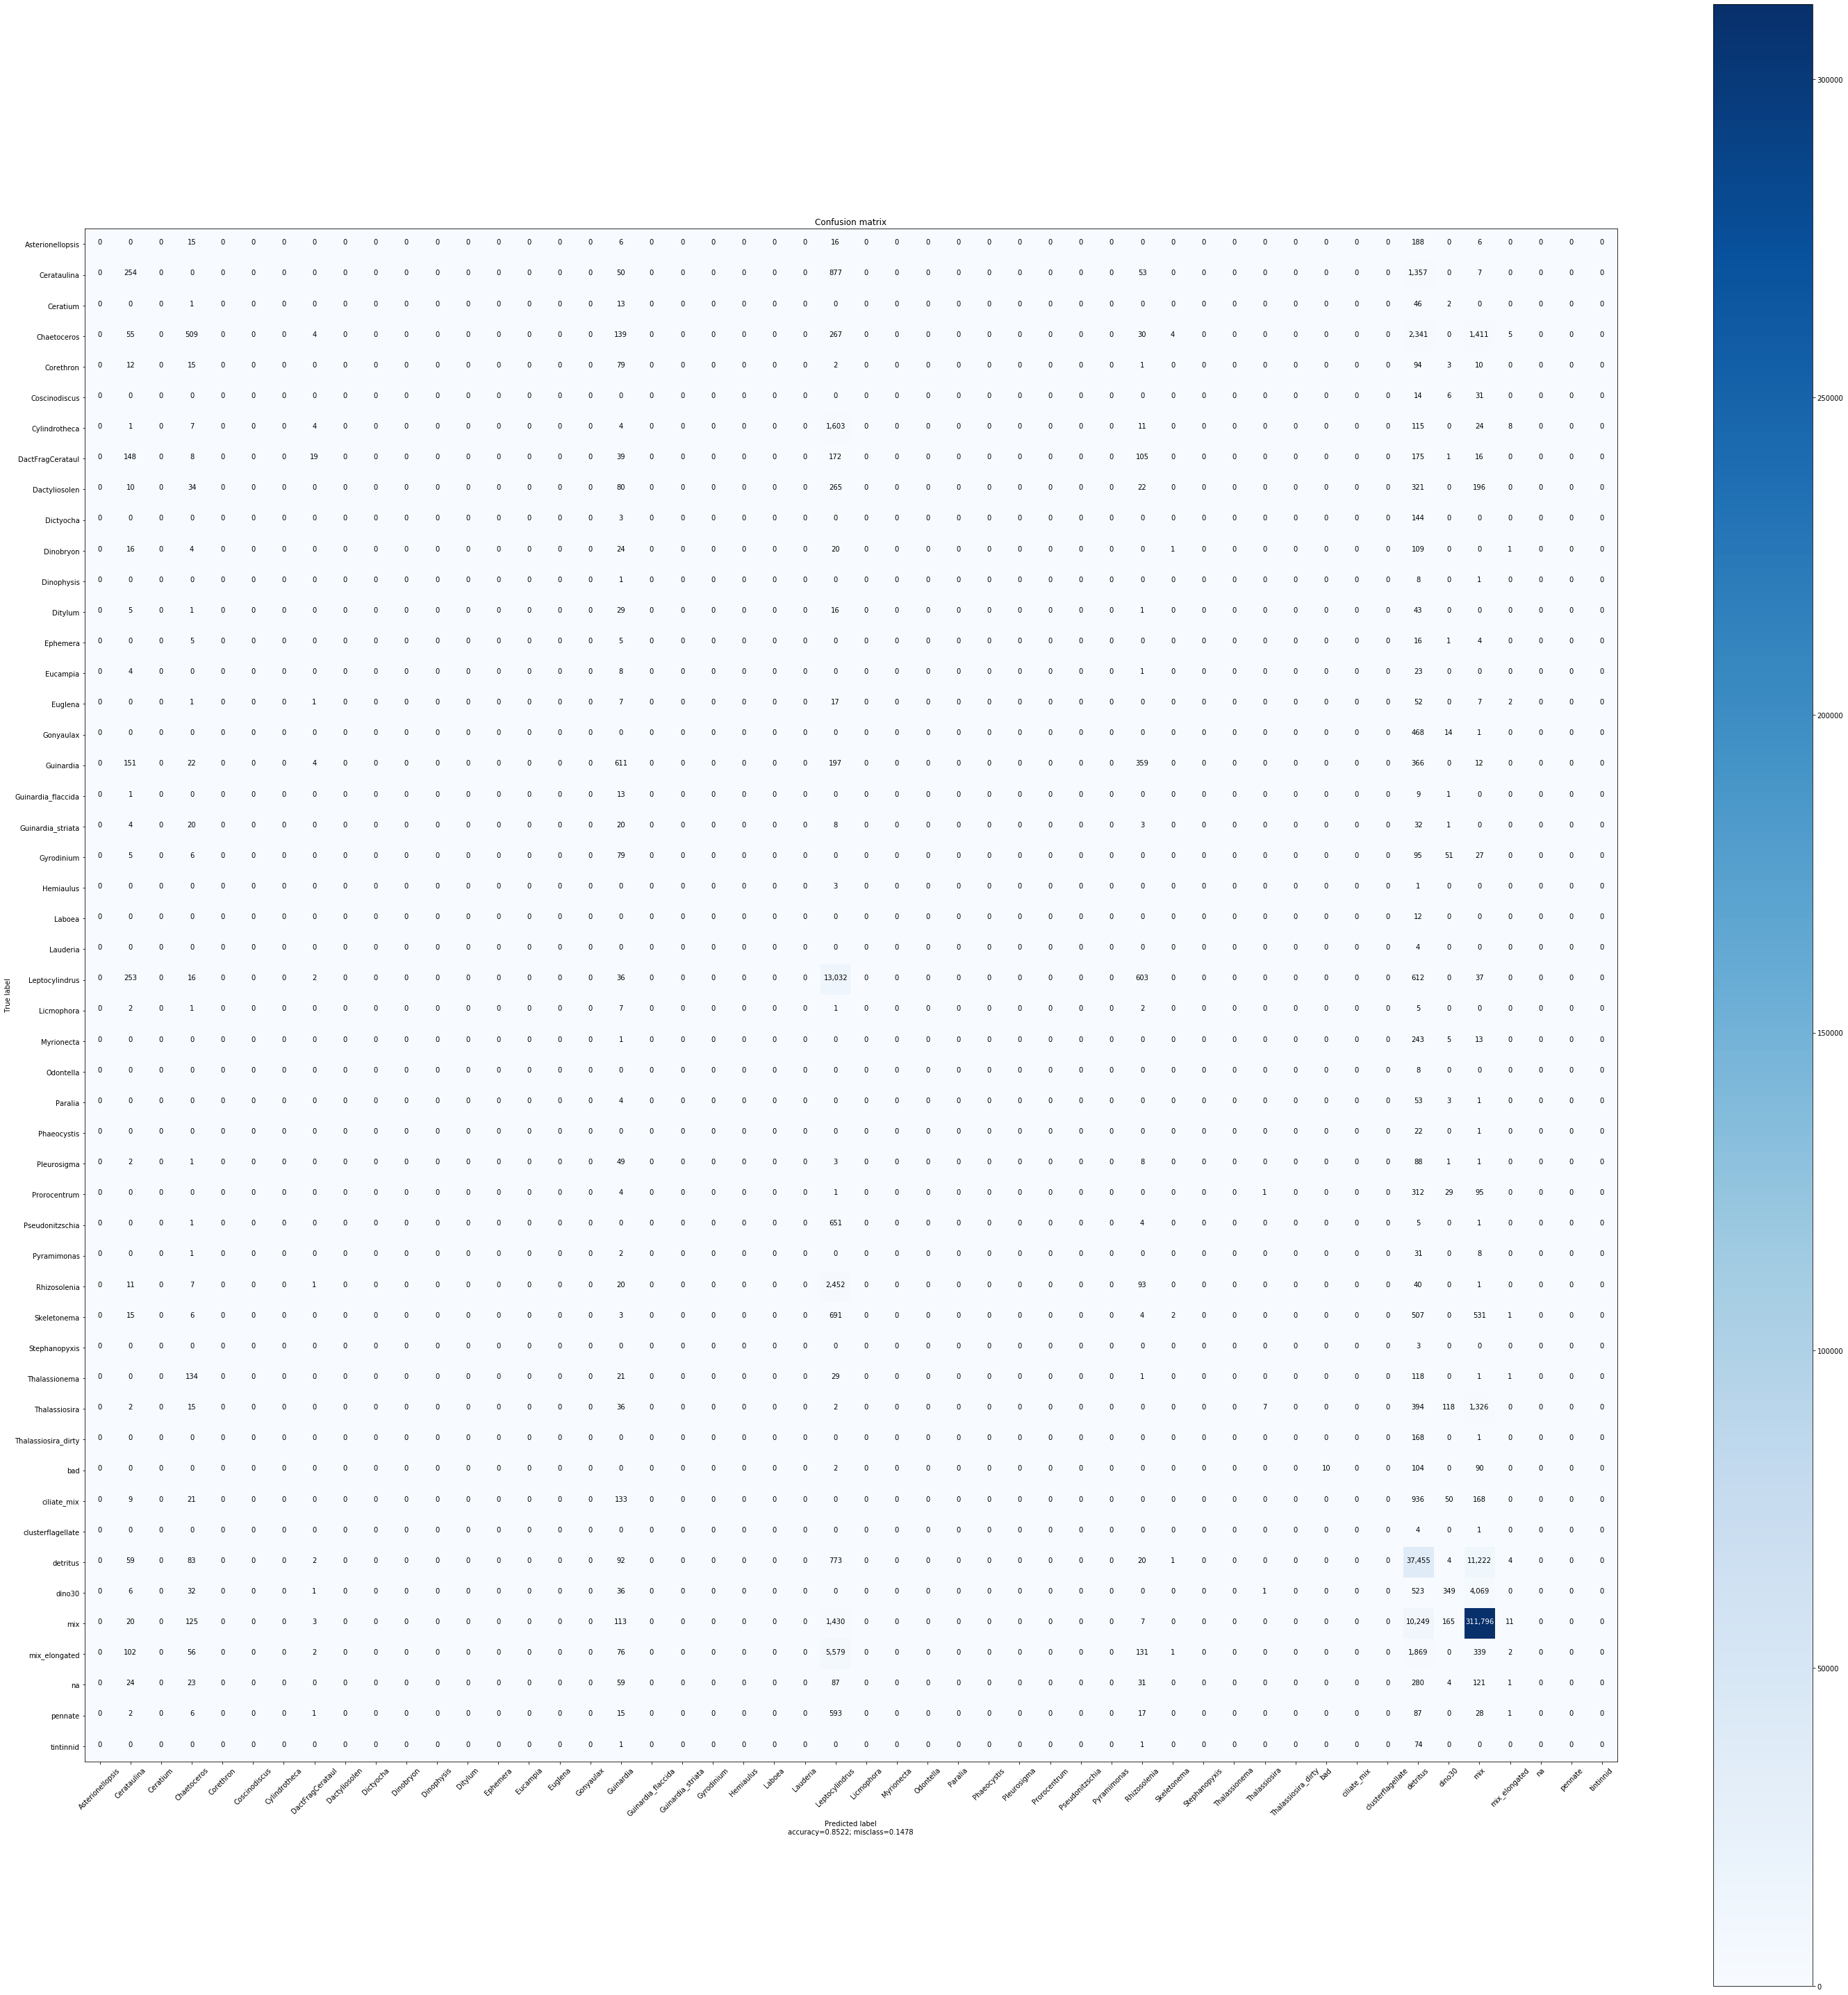

/home/pgonzalez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

   Asterionellopsis       0.00      0.00      0.00       231
        Cerataulina       0.22      0.10      0.13      2598
           Ceratium       0.00      0.00      0.00        62
        Chaetoceros       0.43      0.11      0.17      4765
          Corethron       0.00      0.00      0.00       216
      Coscinodiscus       0.00      0.00      0.00        51
      Cylindrotheca       0.00      0.00      0.00      1777
   DactFragCerataul       0.43      0.03      0.05       683
      Dactyliosolen       0.00      0.00      0.00       928
          Dictyocha       0.00      0.00      0.00       147
          Dinobryon       0.00      0.00      0.00       175
         Dinophysis       0.00      0.00      0.00        10
            Ditylum       0.00      0.00      0.00        95
           Ephemera       0.00      0.00      0.00        31
           Eucampia       0.00      0.00      0.00        36
            Euglena    

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(40,40))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

for p in proportions:
  print('Starting process for proportion %f' % (p))
  model,loss_fn = load_network()
  y_true,y_pred = finetune(model,loss_fn,train_loaders[p],device)
  cm=confusion_matrix(y_true, y_pred)
  labelswithexamples=np.union1d(np.unique(y_true),np.unique(y_pred))
  labelswithexamples_names = np.array(list(val_dset.class_to_idx.keys()))[labelswithexamples]
  plot_confusion_matrix(cm=cm,target_names=labelswithexamples_names,normalize=False)
  print(classification_report(y_true, y_pred,target_names=labelswithexamples_names))